Huilin Chang, Gavin Wiehl, Travis Vitello
DS5559

In [ ]:
import json

In [2]:
# from pyspark import SparkContext
# sc = SparkContext.getOrCreate()

In [3]:
import os
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [4]:
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel

# Load and parse the data
# Read data in json format
df = spark.read.json("reviews_Baby_5.json.gz")

In [5]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

In [6]:
df.show(5)

+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+-------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|097293751X| [0, 0]|    5.0|Perfect for new p...|07 16, 2013|A1HK2FQW6KXQB2|Amanda Johnsen "A...|             Awesine|    1373932800|
|097293751X| [0, 0]|    5.0|This book is such...|06 29, 2013|A19K65VY14D13R|              angela|Should be require...|    1372464000|
|097293751X| [0, 0]|    5.0|Helps me know exa...|03 19, 2014|A2LL1TGG90977E|              Carter|Grandmother watch...|    1395187200|
|097293751X| [0, 0]|    5.0|I bought this a f...|08 17, 2013| A5G19RYX8599E|        cfpurplerose|        repeat buyer|    1376697600|
|097293751X| [0, 0]|    4.0|I wanted an alter...| 04 1, 2014| 

In [7]:
import json
import pandas as pd
data_df = pd.read_json('reviews_Baby_5.json.gz', lines=True)

In [8]:
data_df

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1HK2FQW6KXQB2,097293751X,"Amanda Johnsen ""Amanda E. Johnsen""","[0, 0]",Perfect for new parents. We were able to keep ...,5,Awesine,1373932800,"07 16, 2013"
1,A19K65VY14D13R,097293751X,angela,"[0, 0]",This book is such a life saver. It has been s...,5,Should be required for all new parents!,1372464000,"06 29, 2013"
2,A2LL1TGG90977E,097293751X,Carter,"[0, 0]",Helps me know exactly how my babies day has go...,5,Grandmother watching baby,1395187200,"03 19, 2014"
3,A5G19RYX8599E,097293751X,cfpurplerose,"[0, 0]",I bought this a few times for my older son and...,5,repeat buyer,1376697600,"08 17, 2013"
4,A2496A4EWMLQ7,097293751X,C. Jeter,"[0, 0]",I wanted an alternative to printing out daily ...,4,Great,1396310400,"04 1, 2014"
...,...,...,...,...,...,...,...,...,...
160787,A30J0DKNKCF7SR,B00L13XFIE,SD,"[0, 0]",Bought this as a baby gift and my friend heard...,5,Great baby gift,1391126400,"01 31, 2014"
160788,AG4E44KM93P4L,B00L13XFIE,Silofish,"[0, 1]",I am new to cloth diapering. I was leery that ...,4,Not too bulky,1343606400,"07 30, 2012"
160789,A2UZUH4QHV4HA1,B00L13XFIE,"S. Smith ""sunnshyne309""","[0, 0]",My friend is planning on cloth diapering and I...,5,great help!,1364256000,"03 26, 2013"
160790,A2Z26PUQPMT5JV,B00L13XFIE,Stephanie S. Kim,"[0, 0]",We LOVE the organic cotton/hemp inserts. They'...,5,Love these diapers!,1391731200,"02 7, 2014"


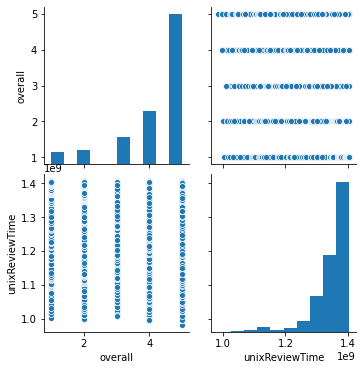

In [9]:
import seaborn as sns
sns.pairplot(data_df)

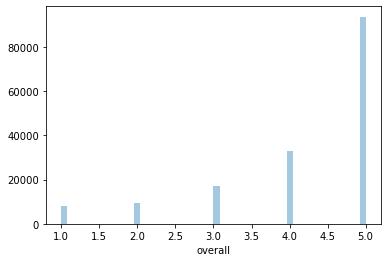

In [10]:
from matplotlib import pyplot as plt
sns.distplot(data_df['overall'],kde = False)
plt.show()

In [11]:
data_df.count()

reviewerID        160792
asin              160792
reviewerName      159427
helpful           160792
reviewText        160792
overall           160792
summary           160792
unixReviewTime    160792
reviewTime        160792
dtype: int64

In [12]:
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

In [13]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [14]:
df_n = df.select("reviewText")

In [15]:
df.describe("overall").show()

+-------+-----------------+
|summary|          overall|
+-------+-----------------+
|  count|           160792|
|   mean|4.214115130105975|
| stddev|1.144324709108409|
|    min|              1.0|
|    max|              5.0|
+-------+-----------------+



## Remove netutal: overall = 3

In [16]:
df1 = df.filter("overall != 3")

In [17]:
from pyspark.ml.feature import Bucketizer
splits = [-float("inf"), 4, float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="overall", outputCol="label")

In [18]:
df2= bucketizer.transform(df1)

In [19]:
df2.groupBy("overall","label").count().show()

+-------+-----+-----+
|overall|label|count|
+-------+-----+-----+
|    2.0|  0.0| 9193|
|    5.0|  1.0|93526|
|    1.0|  0.0| 7819|
|    4.0|  1.0|32999|
+-------+-----+-----+



In [20]:
df3 = df2.groupBy("reviewText","label").count().show()

+--------------------+-----+-----+
|          reviewText|label|count|
+--------------------+-----+-----+
|This item was ext...|  1.0|    1|
|This has been my ...|  1.0|    1|
|We bought these t...|  1.0|    1|
|I was skeptical a...|  1.0|    1|
|In registering an...|  1.0|    1|
|You cannot imagin...|  1.0|    1|
|We needed a gate ...|  1.0|    1|
|This fits well an...|  1.0|    1|
|Easy to install. ...|  1.0|    1|
|This tub is perfe...|  1.0|    1|
|These work great ...|  1.0|    1|
|We have had this ...|  1.0|    1|
|I used to have on...|  1.0|    1|
|These bugs are a ...|  1.0|    1|
|Don't read negati...|  1.0|    1|
|I bought these bo...|  0.0|    1|
|My daughter was n...|  1.0|    1|
|I initially got t...|  1.0|    1|
|I'm not sure if i...|  1.0|    1|
|i love this seat!...|  1.0|    1|
+--------------------+-----+-----+
only showing top 20 rows



## train, test split

In [21]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF

In [273]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="reviewTokenUF")
regexTokenizer = RegexTokenizer(inputCol="reviewText", outputCol="reviewTokenUF", pattern="\\s+|[,.()'!?\"]")

In [274]:
df_tokenized = tokenizer.transform(df2)

In [275]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCol="reviewTokenUF", outputCol="filtered")

In [276]:
df_removed = remover.transform(df_tokenized)

In [277]:
df_removed.take(2)

[Row(asin='097293751X', helpful=[0, 0], overall=5.0, reviewText="Perfect for new parents. We were able to keep track of baby's feeding, sleep and diaper change schedule for the first two and a half months of her life. Made life easier when the doctor would ask questions about habits because we had it all right there!", reviewTime='07 16, 2013', reviewerID='A1HK2FQW6KXQB2', reviewerName='Amanda Johnsen "Amanda E. Johnsen"', summary='Awesine', unixReviewTime=1373932800, label=1.0, reviewTokenUF=['perfect', 'for', 'new', 'parents.', 'we', 'were', 'able', 'to', 'keep', 'track', 'of', "baby's", 'feeding,', 'sleep', 'and', 'diaper', 'change', 'schedule', 'for', 'the', 'first', 'two', 'and', 'a', 'half', 'months', 'of', 'her', 'life.', 'made', 'life', 'easier', 'when', 'the', 'doctor', 'would', 'ask', 'questions', 'about', 'habits', 'because', 'we', 'had', 'it', 'all', 'right', 'there!'], filtered=['perfect', 'new', 'parents.', 'able', 'keep', 'track', "baby's", 'feeding,', 'sleep', 'diaper',

In [278]:
# Convert to TF words vector
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures")
df_TF = hashingTF.transform(df_removed)

In [279]:
df_TF.select(['asin','reviewerID','filtered','rawFeatures']).take(2)

[Row(asin='097293751X', reviewerID='A1HK2FQW6KXQB2', filtered=['perfect', 'new', 'parents.', 'able', 'keep', 'track', "baby's", 'feeding,', 'sleep', 'diaper', 'change', 'schedule', 'first', 'two', 'half', 'months', 'life.', 'made', 'life', 'easier', 'doctor', 'ask', 'questions', 'habits', 'right', 'there!'], rawFeatures=SparseVector(262144, {1546: 1.0, 2286: 1.0, 17252: 1.0, 32890: 1.0, 54800: 1.0, 63154: 1.0, 89833: 1.0, 90723: 1.0, 101464: 1.0, 103839: 1.0, 110647: 1.0, 111105: 1.0, 140784: 1.0, 166277: 1.0, 167301: 1.0, 172517: 1.0, 180475: 1.0, 188835: 1.0, 207475: 1.0, 216086: 1.0, 223059: 1.0, 229166: 1.0, 234553: 1.0, 244857: 1.0, 249593: 1.0, 258728: 1.0})),
 Row(asin='097293751X', reviewerID='A19K65VY14D13R', filtered=['book', 'life', 'saver.', '', 'helpful', 'able', 'go', 'back', 'track', 'trends,', 'answer', 'pediatrician', 'questions,', 'communicate', 'different', 'times', 'night', 'newborn.', '', 'think', 'one', 'things', 'everyone', 'required', 'leave', 'hospital.', '', '

In [280]:
# Convert to TF*IDF words vector
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_TF)
df_idf = idfModel.transform(df_TF)

In [281]:
df_idf.select(['asin','reviewerID','filtered','features']).take(2)

[Row(asin='097293751X', reviewerID='A1HK2FQW6KXQB2', filtered=['perfect', 'new', 'parents.', 'able', 'keep', 'track', "baby's", 'feeding,', 'sleep', 'diaper', 'change', 'schedule', 'first', 'two', 'half', 'months', 'life.', 'made', 'life', 'easier', 'doctor', 'ask', 'questions', 'habits', 'right', 'there!'], features=SparseVector(262144, {1546: 2.1558, 2286: 2.635, 17252: 4.0787, 32890: 2.3273, 54800: 5.4625, 63154: 6.4853, 89833: 2.9193, 90723: 5.2476, 101464: 2.7069, 103839: 6.0164, 110647: 3.1562, 111105: 5.8059, 140784: 2.6274, 166277: 6.1773, 167301: 2.6049, 172517: 4.1822, 180475: 3.3212, 188835: 2.2179, 207475: 6.8118, 216086: 8.0242, 223059: 3.6198, 229166: 2.731, 234553: 3.2861, 244857: 6.5131, 249593: 5.8854, 258728: 2.399})),
 Row(asin='097293751X', reviewerID='A19K65VY14D13R', filtered=['book', 'life', 'saver.', '', 'helpful', 'able', 'go', 'back', 'track', 'trends,', 'answer', 'pediatrician', 'questions,', 'communicate', 'different', 'times', 'night', 'newborn.', '', 'thin

In [282]:
for features_label in df_idf.select("features", "label").take(3):
    print(features_label)

Row(features=SparseVector(262144, {1546: 2.1558, 2286: 2.635, 17252: 4.0787, 32890: 2.3273, 54800: 5.4625, 63154: 6.4853, 89833: 2.9193, 90723: 5.2476, 101464: 2.7069, 103839: 6.0164, 110647: 3.1562, 111105: 5.8059, 140784: 2.6274, 166277: 6.1773, 167301: 2.6049, 172517: 4.1822, 180475: 3.3212, 188835: 2.2179, 207475: 6.8118, 216086: 8.0242, 223059: 3.6198, 229166: 2.731, 234553: 3.2861, 244857: 6.5131, 249593: 5.8854, 258728: 2.399}), label=1.0)
Row(features=SparseVector(262144, {8538: 2.7336, 8694: 5.9582, 16108: 4.6989, 21823: 1.3067, 23717: 5.1848, 25983: 6.9483, 27787: 13.4306, 34225: 6.1218, 37101: 4.6807, 57040: 6.4627, 69650: 5.6943, 79160: 3.3622, 82035: 6.445, 84115: 8.6163, 90592: 3.7606, 101464: 2.7069, 111105: 5.8059, 129946: 6.1639, 131372: 6.2796, 132270: 2.3216, 146139: 3.5622, 148675: 2.5677, 152481: 3.2376, 153423: 2.4274, 159233: 8.5422, 167707: 9.3894, 172517: 4.1822, 174582: 4.7213, 176996: 2.5102, 189113: 10.3228, 189957: 3.3652, 190782: 7.9231, 201547: 2.8012, 21

# split data

In [283]:
# Split data aproximately into training (80%) and test (20%)
# train, test =df2.randomSplit([0.8,0.2], seed = 1234)

# Count Vectorizer

In [284]:
from pyspark.ml.feature import CountVectorizer

In [285]:
count_vec = CountVectorizer(inputCol = "filtered", outputCol = "cv_features")

In [286]:
cv_df = count_vec.fit(df_removed).transform(df_removed)

In [287]:
cv_df.select(['asin','reviewerID','filtered','cv_features']).show(5,False)

+----------+--------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [288]:
count_vec.fit(df_removed).vocabulary

['',
 'baby',
 'one',
 'like',
 'use',
 'great',
 'little',
 'get',
 'love',
 'easy',
 'really',
 'also',
 'it.',
 'much',
 'seat',
 'put',
 'son',
 'bought',
 'still',
 'old',
 'used',
 'even',
 'good',
 'well',
 '-',
 'time',
 'months',
 'using',
 'daughter',
 'first',
 'back',
 'loves',
 'got',
 'car',
 'fit',
 'diaper',
 'keep',
 'two',
 'since',
 'around',
 'nice',
 'make',
 'enough',
 'think',
 'recommend',
 'need',
 '2',
 'stroller',
 'take',
 'product',
 'buy',
 'bag',
 'small',
 'without',
 'go',
 'way',
 'work',
 'month',
 'bottles',
 'works',
 'every',
 'big',
 'size',
 'made',
 'better',
 'perfect',
 'bottle',
 'it,',
 'hold',
 'thing',
 'see',
 'able',
 'soft',
 'bit',
 'never',
 'lot',
 'want',
 'right',
 'easily',
 '3',
 'sure',
 'pretty',
 'makes',
 'fits',
 'different',
 'long',
 'many',
 'hard',
 '4',
 'child',
 'seems',
 'getting',
 'another',
 'know',
 'side',
 'new',
 'clean',
 'play',
 'something',
 'tried',
 'water',
 'wish',
 'going',
 'find',
 'cover',
 'best',

# Text Classification

In [289]:
df_removed.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- label: double (nullable = true)
 |-- reviewTokenUF: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [290]:
df_removed.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|  0.0| 17012|
|  1.0|126525|
+-----+------+



In [291]:
from pyspark.sql.functions import rand

In [292]:
df_removed.select(['asin','filtered','label']).orderBy(rand()).show(3,False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [293]:
from pyspark.sql.functions import length

In [294]:
df_removed = df_removed.withColumn('length',length(df_removed['reviewText']))

In [295]:
df_removed.select(['asin','filtered','length','label']).orderBy(rand()).show(3,False)

+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+-----+
|asin      |filtered                                                                                                                                                                                                                                                     |length|label|
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+-----+
|B0097GUCYM|[bra, perfect., normally, 36dd,, producing, milk, breasts, bigger, that., ordered, xs-l, perfect,, however, almost, loose, goes.i, absolutely, love,

In [296]:
df_removed.groupBy('label').agg({'length':'mean'}).show()

+-----+------------------+
|label|       avg(length)|
+-----+------------------+
|  0.0| 559.3555137549964|
|  1.0|502.50036751630114|
+-----+------------------+



In [297]:
tokenization = Tokenizer(inputCol = 'reviewText', outputCol = 'tokens')

In [298]:
tokenized_df = tokenization.transform(df_removed)

In [299]:
stopword_removal = StopWordsRemover(inputCol = 'tokens', outputCol = 'refined_tokens')

In [300]:
refined_text_df = stopword_removal.transform(tokenized_df)

In [301]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import *

In [302]:
len_udf = udf(lambda s: len(s), IntegerType())
refined_text_df = refined_text_df.withColumn("token_count",len_udf(col('refined_tokens')))

In [303]:
refined_text_df.orderBy(rand()).show(5)

+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+-----+--------------------+--------------------+------+--------------------+--------------------+-----------+
|      asin|helpful|overall|          reviewText| reviewTime|    reviewerID|reviewerName|             summary|unixReviewTime|label|       reviewTokenUF|            filtered|length|              tokens|      refined_tokens|token_count|
+----------+-------+-------+--------------------+-----------+--------------+------------+--------------------+--------------+-----+--------------------+--------------------+------+--------------------+--------------------+-----------+
|B0013IEUJ0| [0, 0]|    4.0|they are exactly ...|04 24, 2012| A81T3X0ERYXZK|   kobbers77|        strap covers|    1335225600|  1.0|[they, are, exact...|[exactly, say, pr...|   122|[they, are, exact...|[exactly, say, pr...|         11|
|B000BPMJR6| [1, 1]|    5.0|After 5 months of...|05 15, 2013

In [304]:
count_vec = CountVectorizer(inputCol = "refined_tokens",outputCol = "features")

In [305]:
cv_text_df = count_vec.fit(refined_text_df).transform(refined_text_df)

In [306]:
cv_text_df.select(['asin','refined_tokens','token_count','features','label']).orderBy(rand()).show(50)

+----------+--------------------+-----------+--------------------+-----+
|      asin|      refined_tokens|token_count|            features|label|
+----------+--------------------+-----------+--------------------+-----+
|B00029T4D8|[first, researche...|         21|(256527,[9,29,79,...|  1.0|
|B001CWDCY6|[cover, fits, per...|         16|(256527,[5,18,57,...|  1.0|
|B0058K5IIQ|[good, floor, mat...|         44|(256527,[3,6,8,9,...|  1.0|
|B00E1CI2W6|[two, full, sized...|         80|(256527,[0,1,2,3,...|  1.0|
|B00B7M7BL6|[toddler, loves, ...|         28|(256527,[6,20,22,...|  1.0|
|B00081J3MW|[plugs, easy, use...|         31|(256527,[2,4,9,15...|  1.0|
|B002M77N22|[bought, baby, sl...|         33|(256527,[1,3,5,11...|  1.0|
|B0051Y1KT0|[felt, like, goig...|         34|(256527,[3,4,7,9,...|  0.0|
|B00158DS0U|[nice, quality,, ...|         12|(256527,[4,40,42,...|  1.0|
|B000LXQVA4|[bought, item, se...|         39|(256527,[1,4,6,10...|  1.0|
|B0012AII9M|[knew, wanted, ad...|         10|(25652

In [307]:
model_text_df = cv_text_df.select(['asin','features','token_count','label'])

In [308]:
from pyspark.ml.feature import VectorAssembler

In [309]:
df_assembler = VectorAssembler(inputCols = ['features','token_count'],outputCol = 'features_vec')

In [310]:
model_text_df = df_assembler.transform(model_text_df)

In [311]:
model_text_df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- token_count: integer (nullable = true)
 |-- label: double (nullable = true)
 |-- features_vec: vector (nullable = true)



In [312]:
from pyspark.ml.classification import LogisticRegression

In [313]:
training_df,test_df = model_text_df.randomSplit([.8,.2]) # Need to give a seed

In [314]:
training_df.count()

114657

In [315]:
test_df.count()

28880

In [316]:
test_df.show(5)

+----------+--------------------+-----------+-----+--------------------+
|      asin|            features|token_count|label|        features_vec|
+----------+--------------------+-----------+-----+--------------------+
|097293751X|(256527,[0,7,13,1...|         29|  1.0|(256528,[0,7,13,1...|
|097293751X|(256527,[1,4,5,9,...|         67|  1.0|(256528,[1,4,5,9,...|
|097293751X|(256527,[1,4,7,13...|        133|  1.0|(256528,[1,4,7,13...|
|9729375011|(256527,[0,1,2,3,...|         54|  1.0|(256528,[0,1,2,3,...|
|9729375011|(256527,[0,1,2,3,...|         55|  1.0|(256528,[0,1,2,3,...|
+----------+--------------------+-----------+-----+--------------------+
only showing top 5 rows



In [317]:
training_df.show(5)

+----------+--------------------+-----------+-----+--------------------+
|      asin|            features|token_count|label|        features_vec|
+----------+--------------------+-----------+-----+--------------------+
|097293751X|(256527,[0,1,2,3,...|         77|  1.0|(256528,[0,1,2,3,...|
|097293751X|(256527,[0,1,2,30...|         51|  1.0|(256528,[0,1,2,30...|
|097293751X|(256527,[0,5,55,1...|         15|  1.0|(256528,[0,5,55,1...|
|097293751X|(256527,[0,9,25,2...|         30|  1.0|(256528,[0,9,25,2...|
|097293751X|(256527,[0,11,54,...|         24|  1.0|(256528,[0,11,54,...|
+----------+--------------------+-----------+-----+--------------------+
only showing top 5 rows



In [318]:
log_reg = LogisticRegression(featuresCol = 'features_vec',labelCol = 'label').fit(training_df) # Consider other models

In [319]:
results = log_reg.evaluate(test_df).predictions
results.show()

+----------+--------------------+-----------+-----+--------------------+--------------------+--------------------+----------+
|      asin|            features|token_count|label|        features_vec|       rawPrediction|         probability|prediction|
+----------+--------------------+-----------+-----+--------------------+--------------------+--------------------+----------+
|097293751X|(256527,[0,7,13,1...|         29|  1.0|(256528,[0,7,13,1...|[-44.164444909934...|[6.60123630180654...|       1.0|
|097293751X|(256527,[1,4,5,9,...|         67|  1.0|(256528,[1,4,5,9,...|[-53.978079478410...|[3.61092059914130...|       1.0|
|097293751X|(256527,[1,4,7,13...|        133|  1.0|(256528,[1,4,7,13...|[-214.55003752732...|[6.63899909958587...|       1.0|
|9729375011|(256527,[0,1,2,3,...|         54|  1.0|(256528,[0,1,2,3,...|[-161.97955740601...|[4.49958061858573...|       1.0|
|9729375011|(256527,[0,1,2,3,...|         55|  1.0|(256528,[0,1,2,3,...|[-101.14654601422...|[1.18198836743938...|    

In [320]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [321]:
true_positives = results[(results.label == 1) & (results.prediction == 1)].count()

In [322]:
true_negatives = results[(results.label == 0) & (results.prediction == 0)].count()

In [323]:
false_positives = results[(results.label == 0) & (results.prediction == 1)].count()

In [324]:
false_negatives = results[(results.label == 1) & (results.prediction == 0)].count()

In [325]:
print(true_positives)
print(true_negatives)
print(false_positives)
print(false_negatives)

23884
1832
1585
1579


In [326]:
import numpy as np

In [327]:
res_array = [(true_positives,false_positives),(false_negatives,true_negatives)]

In [328]:
np.matrix(res_array)

matrix([[23884,  1585],
        [ 1579,  1832]])

In [329]:
recall = float(true_positives)/(true_positives + false_negatives)
precision = float(true_positives)/(true_positives+true_negatives)
accuracy = float(true_positives + true_negatives)/(results.count())
f1 = 2 * (precision*recall)/(precision+recall)

In [330]:
print("Recall = " + str(recall))
print("Precision = " + str(precision))
print("F1 = " + str(f1))
print("Accuracy = " + str(accuracy))

Recall = 0.9379884538349762
Precision = 0.9287603048685643
F1 = 0.9333515699798745
Accuracy = 0.8904432132963989


In [331]:
from pyspark.sql.functions import explode

In [332]:
cv_expl_df = cv_text_df.withColumn("refined_tokens",explode(cv_text_df.refined_tokens))

In [333]:
cv_expl_df_2 = cv_text_df.select(["refined_tokens","label"]).withColumn("refined_tokens",explode(cv_text_df.refined_tokens)).na.drop(subset=["refined_tokens"])

In [334]:
cv_expl_df_2.take(10)

[Row(refined_tokens='perfect', label=1.0),
 Row(refined_tokens='new', label=1.0),
 Row(refined_tokens='parents.', label=1.0),
 Row(refined_tokens='able', label=1.0),
 Row(refined_tokens='keep', label=1.0),
 Row(refined_tokens='track', label=1.0),
 Row(refined_tokens="baby's", label=1.0),
 Row(refined_tokens='feeding,', label=1.0),
 Row(refined_tokens='sleep', label=1.0),
 Row(refined_tokens='diaper', label=1.0)]

In [335]:
cv_expl_df_2 = cv_expl_df_2[cv_expl_df_2.refined_tokens != ""] # eliminate blank spaces!

In [336]:
df_RDD = cv_expl_df_2.select("refined_tokens").rdd.map(list)

In [337]:
df_RDD.map(lambda x: (str(x), 1)).reduceByKey(lambda x,y:x+y).map(lambda x:(x[1],x[0])).sortByKey(False).collect()[0:15]

[(66309, "['baby']"),
 (58258, "['one']"),
 (49357, "['like']"),
 (47271, "['use']"),
 (40498, "['great']"),
 (39760, "['little']"),
 (38032, "['get']"),
 (37549, "['love']"),
 (35684, "['easy']"),
 (34522, "['really']"),
 (30133, "['also']"),
 (29108, "['it.']"),
 (26168, "['much']"),
 (26000, "['seat']"),
 (25615, "['put']")]

In [338]:
df_pos = cv_expl_df_2[cv_expl_df_2["label"] == 1] # positive reviews
df_neg = cv_expl_df_2[cv_expl_df_2["label"] == 0] # negative reviews

In [339]:
df_RDD_pos = df_pos.select("refined_tokens").rdd.map(list)
df_RDD_neg = df_neg.select("refined_tokens").rdd.map(list)

In [340]:
df_RDD_pos.map(lambda x: (str(x), 1)).reduceByKey(lambda x,y:x+y).map(lambda x:(x[1],x[0])).sortByKey(False).collect()[0:15]

[(58691, "['baby']"),
 (51312, "['one']"),
 (43049, "['like']"),
 (41977, "['use']"),
 (38390, "['great']"),
 (36872, "['little']"),
 (36080, "['love']"),
 (34359, "['easy']"),
 (32073, "['get']"),
 (30106, "['really']"),
 (27140, "['also']"),
 (24860, "['it.']"),
 (23231, "['seat']"),
 (22618, "['put']"),
 (22457, "['much']")]

In [341]:
df_RDD_neg.map(lambda x: (str(x), 1)).reduceByKey(lambda x,y:x+y).map(lambda x:(x[1],x[0])).sortByKey(False).collect()[0:15]

[(7618, "['baby']"),
 (6946, "['one']"),
 (6308, "['like']"),
 (5959, "['get']"),
 (5294, "['use']"),
 (4416, "['really']"),
 (4248, "['it.']"),
 (3992, "['even']"),
 (3711, "['much']"),
 (3274, "['bought']"),
 (2997, "['put']"),
 (2993, "['also']"),
 (2904, "['time']"),
 (2888, "['little']"),
 (2885, "['back']")]

In [342]:
#df_pos_2 = spark.createDataFrame(df_RDD_pos)
#df_neg_2 = spark.createDataFrame(df_RDD_neg)

In [343]:
text_pos = df_pos.select("refined_tokens").rdd.flatMap(lambda x: x).collect()
text_neg = df_neg.select("refined_tokens").rdd.flatMap(lambda x: x).collect()

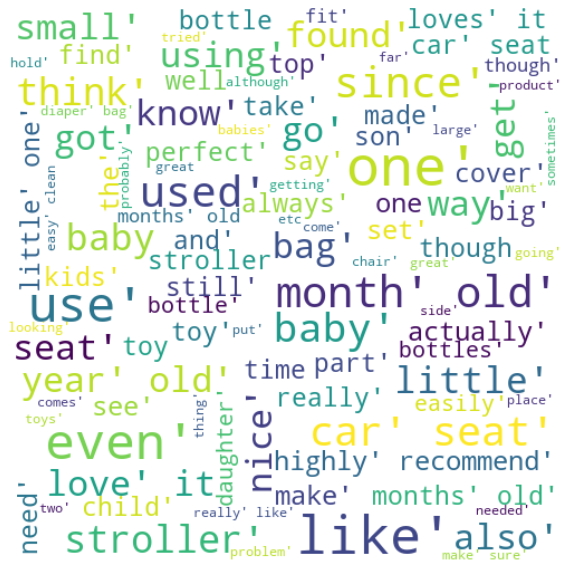

In [344]:
wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white",width=500, height=500)\
.generate(str(text_pos))
plt.figure()
plt.rcParams["figure.figsize"] = (10,30)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.show()

# https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
# https://hendra-herviawan.github.io/pyspark-dataframe-row-columns.html
# https://stackoverflow.com/questions/38610559/convert-spark-dataframe-column-to-python-list
# https://www.datacamp.com/community/tutorials/wordcloud-python
#https://www.geeksforgeeks.org/generating-word-cloud-python/
# https://www.mikulskibartosz.name/how-to-change-plot-size-in-jupyter-notebook/

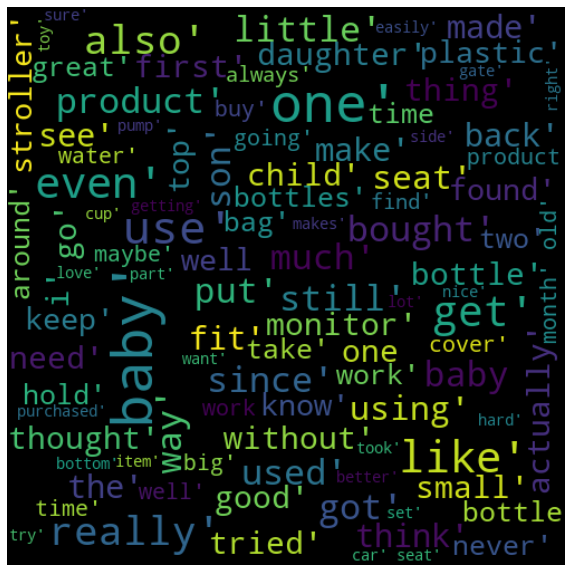

In [345]:
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="black",width=500, height=500)\
.generate(str(text_neg))
plt.figure()
plt.rcParams["figure.figsize"] = (10,30)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show()